# TS2Vec Changepoint Detector
This notebook presents an example of simulated AR(1) data with changes in means and applying the TS2Vec Changepoint Detector to indentify the changepoints. 
This notebook was used in a google colab environment, and paths to depencies may need to be edited to make this project function. 

In [ ]:
# Setting up the environment
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Adding dirs to pythonpath
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/sim_gen/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec_cpd/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# @title Generate Simulated Data Function

from sim_gen import milestone_2_sim
import numpy as np

def generate_simulated_data(n_instances=1000, train_split=0.8, M=2, L=450, pct_no_changepoints=10, sim_method=None, **sim_kwargs):
    """
    Generates simulated time series data with changepoints, performs z-score normalisation,
    and splits the data into training and testing sets with corresponding ground truth changepoints.

    Args:
        n_instances: The total number of time series instances to generate.
        train_split: The proportion of data to use for training.
        M : How many changepoints
        L: Maximum length of instances (pad shorter, truncate longer)
        pct_no_changepoints: The percentage of instances to generate with no changepoints (M=0).
        sim_method: The simulation method to use for generating data.
        **sim_kwargs: Additional keyword arguments to pass to the sim_method.

    Returns:
        tuple: A tuple containing:
            - train_data (np.ndarray): Training data (n_train_instances, L, n_features).
            - test_data (np.ndarray): Testing data (n_test_instances, L, n_features).
            - train_ground_truth_cps (list): List of ground truth changepoints for the training data.
            - test_ground_truth_cps (list): List of ground truth changepoints for the testing data.
    """
    synthetic_normalised_data = []
    synthetic_cps = []

    if not sim_method:
        sim_method = milestone_2_sim.generate_changepoint_ar_data

    # Set default S value if not provided in sim_kwargs
    if 'S' not in sim_kwargs:
        sim_kwargs['S'] = [3.0]

    # Loop to generate data
    for _ in range(n_instances):
        # Randomly choose if this instance should have no changepoints
        generate_no_changepoints = np.random.rand() < (pct_no_changepoints / 100.0)

        if generate_no_changepoints:
            # Generate a single instance of data with no changepoints (M=0)
            # Filter out S parameter for no changepoints case
            no_cp_kwargs = {k: v for k, v in sim_kwargs.items() if k != 'S'}
            data, cps, _ = sim_method(M=0, **no_cp_kwargs)
        else:
            # Generate a single instance of data with changepoints
            data, cps, _ = sim_method(M=M, **sim_kwargs)

        # setting correct shape
        data = data.reshape(-1, 1)

        # Calculate mean and standard deviation, avoiding division by zero for constant data
        mean = np.mean(data, axis=0)
        std_dev = np.std(data, axis=0)
        normalised_data = np.zeros_like(data)
        non_zero_std_mask = std_dev != 0
        normalised_data[:, non_zero_std_mask] = (data[:, non_zero_std_mask] - mean[non_zero_std_mask]) / std_dev[non_zero_std_mask]

        # Pad or truncate to exact length L
        if normalised_data.shape[0] < L:
            # Pad shorter sequences
            padding_length = L - normalised_data.shape[0]
            padded_data = np.pad(normalised_data, ((0, padding_length), (0, 0)), mode='constant', constant_values=np.nan)
        elif normalised_data.shape[0] > L:
            # Truncate longer sequences
            padded_data = normalised_data[:L]
        else:
            padded_data = normalised_data

        synthetic_normalised_data.append(padded_data)
        synthetic_cps.append(cps)

    # Split data into training and testing sets
    train_size = int(train_split * n_instances)
    train_data_list = synthetic_normalised_data[:train_size]
    test_data_list = synthetic_normalised_data[train_size:]
    train_ground_truth_cps = synthetic_cps[:train_size]
    test_ground_truth_cps = synthetic_cps[train_size:]

    # Convert the list of arrays into a single NumPy array
    # We handle cases where train_split is 0 or 1, resulting in empty lists
    train_data_gen = np.stack(train_data_list, axis=0) if train_data_list else np.array([])
    test_data_gen = np.stack(test_data_list, axis=0) if test_data_list else np.array([])

    # Return the generated data and changepoints
    return train_data_gen, test_data_gen, train_ground_truth_cps, test_ground_truth_cps

In [ ]:
# @title Generating simulated data and training the TS2Vec model
from ts2vec_cpd import train_ts2vec_model, TS2VecChangepointDetector, evaluate_changepoint_detection, triangular_filter

train_data_gen, test_data_gen, train_ground_truth_cps, test_ground_truth_cps = generate_simulated_data(n_instances=10, train_split=1.0, M=2, pct_no_changepoints=10)

# Train the TS2Vec model
trained_model = train_ts2vec_model(
    train_data=train_data_gen,
    input_dims=train_data_gen.shape[-1],
    device=0
)

Training TS2Vec model...
TS2Vec model training complete.


In [4]:
# @title Plot Results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(data, ground_truth_cps, filtered_l2_distances, detected_cps):
    """
    Plots the time series data, ground truth changepoints, and detected changepoints
    Left: Time series data with ground truth and detected changepoints
    Right: L2 distance signals (unfiltered and filtered) with detected peaks
    """

    # Ensure data is 2D for plotting (n_timestamps, n_features)
    if data.ndim == 3:
        data = data.squeeze(0)
    elif data.ndim == 1:
        data = data[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Time Series Data
    axes[0].plot(data.flatten(), label='Time Series Data', linewidth=1.2)
    axes[0].set_title('Time Series Data', fontweight='bold')
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel('Time')
    axes[0].grid(False)

    # Plot ground truth changepoints
    if ground_truth_cps:
        for cp in ground_truth_cps:
            axes[0].axvline(x=cp, color='#E74C3C', linestyle='--', linewidth=2, label='Ground Truth CP')

    # Plot detected changepoints on the time series data
    if detected_cps:
        for d_cp in detected_cps:
            axes[0].axvline(x=d_cp, color='#2ECC71', linestyle='-', linewidth=2, label='Detected CP')

    # Plot L2 Distance signals on the second subplot
    signal_x_axis = np.arange(len(filtered_l2_distances))
    axes[1].plot(signal_x_axis, filtered_l2_distances, label='Smoothed L2 Distance', color='#8E44AD', linestyle='-', linewidth=2)
    axes[1].set_title('L2 Distance Signals', fontweight='bold')
    axes[1].set_ylabel('L2 Distance')
    axes[1].set_xlabel('Time')
    axes[1].grid(False)

    # Plot detected peaks as vertical lines on the L2 distance plot
    if detected_cps is not None and len(detected_cps) > 0:
        for d_cp in detected_cps:
              axes[1].axvline(x=d_cp, color='#2ECC71', linestyle='-', linewidth=2, label='Detected Changepoints')

    plt.show()

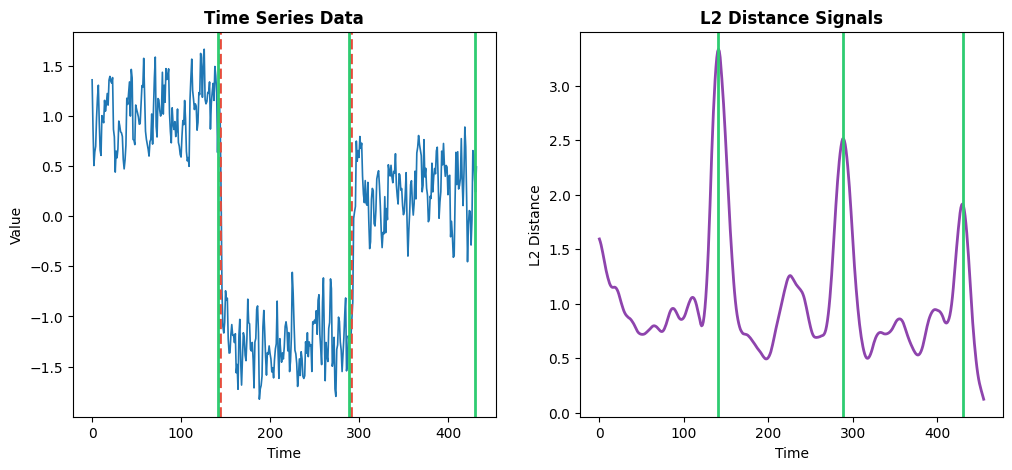

In [5]:
# @title Plot one with best ts2vec params

# Instantiate the TS2VecChangepointDetector
best_detector = TS2VecChangepointDetector(
    model=trained_model,
    sliding_padding=12,
    local_window_size=12,
    prominence_threshold=1.0,
)

# Generate one new data point for analysis
_, evaluation_data_single, _, evaluation_ground_truth_cps_single = generate_simulated_data(n_instances=1, train_split=0.0, S=[3.0])

instance_data = evaluation_data_single[0]
instance_ground_truth_cps = evaluation_ground_truth_cps_single[0]

detected_changepoints, filtered_l2 = best_detector.detect_changepoints(instance_data)

plot_results(
    data=instance_data,
    ground_truth_cps=instance_ground_truth_cps,
    filtered_l2_distances=filtered_l2,
    detected_cps=detected_changepoints
)